### RNN_DIVERSE_NETWORKS_
1. One-To-One Network
    - Vanilla Neural Networks
2. One-To-Many Network
    - Image Captioning (Image -> Sequence of Words)
3. Many-To-One Network
    - Sentiment Classifiation ( Sequence of Words -> Sentiment )
4. Many-To-Many Network
    - Machine Translation ( Sequence of Words -> Sequence of Words )
    - Video Classification on Frame Level

**문자로 구성된 데이터에 대해서 전처리를 함에 있어서 일정한 순서및 반드시 해야 하는 것이 있음을 알게 되었다.**
1. 특수 문자등 전처리 해주기(Preprocessing + Text Augmentation)  
```
import re
re.findall("[a-zA-Z]+", text)```  
- 이런 방법으로 정규 표현식을 이용해서 필요 없는 문자를 지워주고 위와 같이 알파벳만을 추출해 주는 방법도 존재한다.
```import nltk```를 해서 주어진 함수를 이용하는 방법도 존재
```
def preprocess(data):
    data = tf.strings.stbstr(data, 0, max_word)
    data = tf.strings.regex_replace(data, b"<br\\s*/?>", b" ")
    data = tf.strings.regex_replace(data, b"[^a-zA-Z']", b" ")
    data = tf.strings.split(data)
    return data.to_tensor(default_value = b"<pad>")
```
위와 같이 간단한 함수로도 충분히 불필요한 문자를 제거하고 모자란 길이를 '<pad>' 로 채워 주는 것이 가능하다. 

2. Tokenization
- 문장을 단어 단위로, 단어를 형태소 단위로 쪼개는 등 신경망의 각각의 unit들이 한번에 받아 들일 단위로 쪼개어 준다.
    - 이 하나의 단위를 token이라고 한다.
- 이는 보통 split을 이용해서 파이썬 문법을 이용하거나
- ```tf.keras.preprocessing.text.Tokenizer(input)```을 이용해서 tokenizing을 쉽게 할 수 있다.
```t = Tokenizer()
    t.fit(data)
    x = t.text_to_sequences(data)```   
이런 식으로 하면 각 token이 수치화 되어 딥러닝 모델에 입력될 준비가 된 것이다.    
        

3. Padding
- 전처리 단계에서 진행해 주어도 되지만 ```tf.keras.preprocessing.sequence.pad_sequences(input, maxlen, padding = 'post')```이런 식으로 간편하게 pad_sequences를 이용해서 처리가 가능하다.

4. Embedding
- 시퀀스 데이터에서 의미있는 결과를 도출하고 싶다면 Embedding은 필수이다.
- 각각의 token벡터들 사이의 관계를 학습을 할 수 있기 때문이다.
    - Embedding() layer는 (batch_size, input_length)의 2D tensor을 입력받고
    - (batch_size, input_length, embedding_dimension)의 3D tensor을 출력한다.
- 입력받는 parameter은
    - vocab_size: 전체 단어 집합의 크기
    - output_dim: embedding_dimension과 같은 값으로, 임베딩 후 임베딩 벡터의 차원
    - input_length: 입력 sequence의 길이
    

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import numpy as np

### 1. Many-To-One Network
**1. 간단하게 'hello'라는 단어를 입력해 다음 단어를 예측하는 RNN을 짜보고자 한다.**
1. input_size = 4, hidden_size = 2인 모델을 만들어 볼 것이다.
2. 문자를 벡터로 바꾸는 방법은 여러개가 있겠지만, 우선은 one-hot-encoding을 이용해서 벡터로 바꿀 것이다.
3. 밑의 코드에서 output은 나온 H(t)값이고 state는 옆으로 이동해서 영향을 줄 값이다.
4. hidden_size, 즉 출력의 크기가 2이기 때문에 출력 뉴런의 개수가 2라는 의미이고 즉 나온 output과 state의 각각의 값은 둘 다 다음 값을 각각의 뉴런이 예측한 값이다.

In [ ]:
h,e,l,o = [1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]

x_data = np.array([[h]], dtype = np.float32)

hidden_size = 2
cell = layer.SimpleRNNCell(units = hidden_size)
rnn = layer.RNN(cell, return_sequences = True, return_state = True)
outputs, state = rnn(x_data)

print("x_data : {} x_data_shape : {}".format(x_data, x_data.shape))
print("output : {} output_shape : {}".format(outputs, outputs.shape))
print("state : {} state_shape : {}".format(state, state.shape))

### 2. Many-To-One
1. 문자열 시퀀스를 입력받을 때에는 일반적으로 문자열을 tokenization을 통해 분할하고 keras의 embedding layer을 이용해서 벡터화한 데이터를 RNN이 사용할 수 있도록 해준다.
2. 이번에는 단어를 입력하는 것이므로 토큰화를 한다면 글자 별로 하게 될 것이다.

In [ ]:
words = ['good', 'bad', 'worse', 'so good']
y_data = [1,0,0,1]

#토큰화한 문자에 대한 사전을 만든다.
token_dict = ['<pad>'] + sorted(list(set(''.join(words))))
char_2idx = {idx : char for idx, char in enumerate(token_dict)}
idx_2char = {char : idx for idx, char in enumerate(token_dict)}

print(token_dict)
print(idx_2char)
print(char_2idx)

In [ ]:
x_data = list(map(lambda x : [idx_2char.get(char) for char in x], words))
print(x_data)
max_sequence = 10

from tensorflow.keras.preprocessing.sequence import pad_sequences
#pad_sequence는 기본적으로 0으로 빈 자리를 padding해준다.
#이를 해주는 이유는 max_sequence의 길이인 10으로 모든 데이터의 길이를 통일 시켜 주어야만 RNN이 학습을 할 수 있기 때문이다.
x_data = pad_sequences(sequences = x_data, maxlen = max_sequence, padding = 'post', truncating = 'post')
#pad_sequence에 넣은 parameter의 값들은 모두 뒤의 넘치는 값들을 없애 줄것이라는 의미이다.
#trunctaing은 넘치면 어떻게 할 것인지, padding은 모자라면 어떻게 할 것인지를 결정 짓게 하는 변수이다.
print(x_data)

```
tf.keras.layers.Embedding(
    input_dim,
    output_dim,
    embeddings_initializer="uniform",
    embeddings_regularizer=None,
    activity_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    input_length=None,
    **kwargs
)
```   
위의 내용이 원래 Embedding layer안에서 결정 지어 줄 수 있는 변수들이다.
1. embeddings_initializer: Initializer for the embeddings matrix ```keras.initializers```
2. embeddings_regularizer: Regularizer function applied to the embeddings matrix ```keras.regularizers```
3. embeddings_constraint: Constraint function applied to the embeddings matrix ```keras.constraints```

In [ ]:
input_dim = len(char_2idx)
output_dim = len(char_2idx)

hidden_size = 10
num_classes = 2

#np.eye(n, dtype = int)같은 식으로 하면 3개만큼 [[1,0,0],[0,1,0],[0,0,1]] 이런식으로 해당 단어의 index값으로 one-hot-encoding을 한다.
one_hot = np.eye(len(char_2idx))
model = keras.models.Sequential()
model.add(layer.Embedding(input_dim = input_dim, output_dim = output_dim, trainable = False, mask_zero = True, 
                          input_length = max_sequence, embeddings_initializer = keras.initializers.Constant(one_hot)))
model.add(layer.SimpleRNN(units = hidden_size))
model.add(layer.Dense(units = num_classes))
model.summary()

#classification문제이기 떄문에 crossentropy를 사용하고, label인 y가 integer의 형태, 즉 one-hot이 아니기 떄문에 sparse를 사용한다.
def loss_fn(model,x,y):
    return keras.losses.sparse_categorical_crossentropy(y_true = y, y_pred = model(x), from_logits = True)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)

dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data)).shuffle(4).batch(2)
dataset

In [ ]:
losses = []
epochs = 30
for i in range(epochs):
    avg_train_loss = 0
    train_step = 0
    
    for x,y in dataset:
        with tf.GradientTape() as tape:
            loss = loss_fn(model, x, y)
        gradient = tape.gradient(loss, model.variables)
        optimizer.apply_gradients(zip(gradient, model.variables))
        avg_train_loss += loss
        train_step += 1
        
    else:
        avg_train_loss /= train_step
        losses.append(avg_train_loss)
        
    if (i%5 == 0):
        print("Epoch : {} Loss : {}".format(i+1, avg_train_loss))

### 3. Many-To-One Stacked Network

In [ ]:
#1. dataset 만들기
sentences = ['When life offers you a dream so far beyond any of your expectations, it’s not reasonable to grieve when it comes to an end.',
            'I said it would be better if we weren’t friends, not that I didn’t want to be.',
            'And third, I was unconditionally and irrevocably in love with him.',
            'No matter how perfect the day is, it always has to end.']
y_label = [1,0,1,0] #1:Bella Swan 2:Edward Cullen

char_set = ['<pad>'] + sorted(list(set(''.join(sentences))))
char_2idx = {char : idx  for idx, char in enumerate(char_set)}
idx_2char = {idx : char for idx, char in enumerate(char_set)}

In [ ]:
x_data = list(map(lambda x: [char_2idx.get(word) for word in x], sentences))
x_datalen = list(map(lambda x: len(x), x_data))

max_sequence = 90
#빈자리나 남는 자리를 채워서 max_sequence에 맞게 입력 데이터를 만들기 위해 pad_sequence 사용
x_data = pad_sequences(x_data, max_sequence, padding = 'post', truncating = 'post')

In [ ]:
#model 만들기
num_classes = 2
hidden_dims = [10,10]

input_dim = len(char_2idx)
output_dim = len(char_2idx)
one_hot = np.eye(len(char_2idx))

model=keras.models.Sequential()
#mask_zero = True로 설정해 주는 방법으로 입력 데이터의 0은 무시해 준다.
model.add(keras.layers.Embedding(input_dim = input_dim, output_dim = output_dim, 
                                trainable = False, mask_zero = True, input_length = max_sequence,
                                embeddings_initializer = keras.initializers.Constant(one_hot)))
model.add(keras.layers.SimpleRNN(units = hidden_dims[0], return_sequences = True))
#TimeDistributed layer는 모든 타임 스텝에 Dropout을 적용하기 위해서 사용이 된다.
#이 층은 다른 층을 감싸서 입력 시퀀스의 모든 타임 스텝에 적용을 하게 한다.
model.add(keras.layers.TimeDistributed(layer.Dropout(0.3)))
model.add(keras.layers.SimpleRNN(units = hidden_dims[1]))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(units = num_classes))
model.summary()

In [ ]:
#model에 dropout layer이 있는데 이는 training 단계에서만 활용하기 때문에 이를 조절해 주기 위해서 training 변수를 loss_fn에 추가한다.
def loss_fn(model, x,y,training):
    return tf.compat.v1.losses.sparse_softmax_cross_entropy(labels=y, logits = model(x, training))

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)
dataset = tf.data.Dataset.from_tensor_slices((x_data, y_label)).shuffle(4).batch(2)

dataset

In [ ]:
epochs = 30
losses = []
for i in range(epochs):
    avg_loss = 0
    train_step = 0
    for x,y, in dataset:
        with tf.GradientTape() as tape:
            loss = loss_fn(model, x,y,training = True)
        gradient = tape.gradient(loss, model.variables)
        optimizer.apply_gradients(zip(gradient, model.variables))
        avg_loss += loss
        train_step += 1
    else:
        avg_loss /= train_step
    losses.append(avg_loss)
    if i%5 == 0:
        print('Epochs : {} Loss : {}'.format(i+1, avg_loss))

In [ ]:
np.argmax(model.predict(x_data),axis = -1)

### 4. Many-To-Many Network
- 기존에 사용했던 Many-To-One이 마지막으로 입력받는 token에 대한 출력 값을 내보내는 것과 달리 입력으로 받는 각각의 토큰에 대해 하나씩의 input을 내보내게 된다.
- 이번에는 간단한 데이터셋을 준비해서
1. 각각의 sentence를 word 단위로 tokenization을 진행
2. 각각의 token에 대해 어떤 word of speech, 즉 품사를 갖고 있는지 tagging을 해보는 것을 모델링

In [39]:
#dataset 준비
sentences = [['I','feel', 'hungry'],
             ['tensorflow', 'is', 'very', 'difficult'],
             ['tensorflow', 'is', 'a', 'framework', 'for', 'deep','learning'],
             ['tensorflow', 'is', 'very', 'fast', 'changing']]
pos = [['pronoun', 'verb', 'adjective'],
      ['noun', 'verb', 'adverb', 'adjective'],
      ['noun', 'verb', 'determiner', 'noun', 'preposition', 'adjective', 'noun'],
      ['noun', 'verb', 'adverb', 'adjective', 'verb']]

word_list = ['<pad>'] + sorted(set(sum(sentences, [])))
word2_idx = {word : idx for idx, word in enumerate(word_list)}
idx2_word = {idx : word for idx, word in enumerate(word_list)}

pos_list = ['<pad>'] + sorted(set(sum(pos, [])))
pos2_idx = {pos : idx for idx, pos in enumerate(pos_list)}
idx2_pos = {idx : pos for idx, pos in enumerate(pos_list)}


              

In [40]:
x_data = list(map(lambda sentence : [word2_idx.get(token) for token in sentence], sentences))
y_data = list(map(lambda pos : [pos2_idx.get(token) for token in pos], pos))

In [41]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_sequences = 10
x_data = pad_sequences(sequences = x_data, maxlen = max_sequences, padding = 'post')
#나중에 오차 역전파를 계산할 때에 길이를 맞춰주기 위해 추가한 <pad>에 대해서는 loss를 계산하지 않을 것이기 때문에
#미리 masking을 해놓은 데이터를 마련한다.
x_data_mask = ((x_data != 0) * 1).astype(np.float32)
x_data_len = list(map(lambda sentence: len(sentence), sentences))
y_data = pad_sequences(sequences = y_data, maxlen = max_sequences, padding = 'post')

In [42]:
x_data_len

[3, 4, 7, 5]

In [43]:
x_data_mask

array([[1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [44]:
num_classes = len(pos2_idx)
hidden_dim = 10

input_dim = len(word2_idx)
output_dim = len(word2_idx)
one_hot = np.eye(len(word2_idx))

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim = input_dim, output_dim = output_dim, 
                                   mask_zero = True, trainable = False, input_length = max_sequences,
                                   embeddings_initializer = tf.keras.initializers.Constant(one_hot)))

In [45]:
#Embedding layer까지만 만들고 이와 같은 값을 출력해 보았는데 보니까 아래 와 같이, 입력된 각각의 token에 대해서 one_hot의 방법으로 
#바꾸어서 output_dim의 길이의 행렬들로 각각을 표현했다.
print(model(x_data))

tf.Tensor(
[[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0.

In [85]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim = input_dim, output_dim = output_dim, 
                                   mask_zero = True, trainable = False, input_length = max_sequences,
                                   embeddings_initializer = tf.keras.initializers.Constant(one_hot)))
model.add(tf.keras.layers.GRU(units = hidden_dim, return_sequences = True))
model.add(tf.keras.layers.SimpleRNN(units = hidden_dim, return_sequences = True))
#모든 token에 대해 입력값을 출력해야 하기 때문에 TImeDistribution에 Dense를 넣어서 사용한다.
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units = num_classes)))

In [81]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 10, 15)            225       
_________________________________________________________________
gru_1 (GRU)                  (None, 10, 10)            810       
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 10, 10)            210       
_________________________________________________________________
time_distributed_7 (TimeDist (None, 10, 8)             88        
Total params: 1,333
Trainable params: 1,108
Non-trainable params: 225
_________________________________________________________________


In [82]:
def loss_fn(model, x,y,x_len, max_sequence):
    masking = tf.sequence_mask(x_len, max_sequence, dtype = tf.float32)
    valid_time_step = tf.cast(x_len, dtype = tf.float32)
    #<pad>데이터는 고려하지 않기 위해서 masking을 함
    #최종 데이터인 y와 model에 x를 넣은 값에 대해 손실을 계산
    sequence_loss = tf.compat.v1.losses.sparse_softmax_cross_entropy(labels = y, logits = model(x), reduction = 'none') * masking
    
    #reduce_sum()에서 axis = -1이라는 것을 시간 축을 기준으로 거꾸로 loss값을 더해 나간다는 의미이다.
    sequence_loss = tf.reduce_sum(sequence_loss, axis = -1)/valid_time_step
    sequence_loss = tf.reduce_mean(sequence_loss)
    return sequence_loss

In [83]:
learning_rate = 0.2
epochs = 30
batch_size = 2
optimizer = tf.keras.optimizers.Adam(learning_rate)

dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data, x_data_len))
dataset = dataset.shuffle(4).batch(batch_size)

In [84]:
train_loss = []

for i in range(epochs):
    loss_avg = 0
    step = 0
    for x,y,x_len in dataset:
        with tf.GradientTape() as tape:
            loss = loss_fn(model,x,y,x_len, max_sequences)
        gradient = tape.gradient(loss, model.variables)
        optimizer.apply_gradients(zip(gradient, model.variables))
        loss_avg += loss
        step += 1
    else:
        loss_avg /= step
        train_loss.append(loss_avg)
        
    if i %5 == 1:
        print('Epoch : {} Loss : {}'.format(i, loss_avg))
        

Epoch : 1 Loss : 2.062488555908203
Epoch : 6 Loss : 0.07001030445098877
Epoch : 11 Loss : 0.006468089297413826
Epoch : 16 Loss : 0.0017009892035275698
Epoch : 21 Loss : 0.0009575319709256291
Epoch : 26 Loss : 0.0006197222974151373


In [86]:
y_predict = model.predict(x_data)

In [90]:
np.argmax(y_predict, axis = -1)*x_data_mask

array([[6., 7., 7., 0., 0., 0., 0., 0., 0., 0.],
       [3., 4., 0., 4., 0., 0., 0., 0., 0., 0.],
       [3., 4., 4., 7., 7., 7., 6., 0., 0., 0.],
       [3., 4., 0., 4., 4., 0., 0., 0., 0., 0.]])

### 5. Many-To-Many Bidirectional
- forward RNN과 backward RNN을 가지고 있는 network이다.
- 손실의 계산은 이전의 many-to-many와 동일하지만 각각의 토큰에 대해 각각 한번씩 더 진행해 주어야 한다는 차이가 존재한다.

In [111]:
num_classes = len(pos2_idx)
max_sequence = 10

hidden_dim = 10
input_dim = len(word2_idx)
output_dim = len(word2_idx)
one_hot = np.eye(len(word2_idx))

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape = [10,]))
model.add(tf.keras.layers.Embedding(input_dim = input_dim, output_dim = output_dim, 
                                   embeddings_initializer = tf.keras.initializers.Constant(one_hot),
                                   input_length = max_sequence, mask_zero = True, trainable = False))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units = hidden_dim, return_sequences = True)))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units = num_classes)))

In [112]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 10, 15)            225       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10, 20)            520       
_________________________________________________________________
time_distributed_11 (TimeDis (None, 10, 8)             168       
Total params: 913
Trainable params: 688
Non-trainable params: 225
_________________________________________________________________


In [113]:
def loss_fn(model, x, y, x_len, max_sequence):
    masking = tf.sequence_mask(x_len, maxlen = max_sequence, dtype = tf.float32)
    valid_time_step = tf.cast(x_len, dtype = tf.float32)
    loss = tf.compat.v1.losses.sparse_softmax_cross_entropy(y, logits = model(x)) * masking
    
    sequence_loss = tf.reduce_sum(loss, axis = -1)/valid_time_step
    sequence_loss = tf.reduce_mean(sequence_loss)
    return sequence_loss    

In [114]:
train_loss = []
for i in range(epochs):
    avg_loss, step = 0,0
    for x,y,x_len in dataset:
        with tf.GradientTape() as tape:
            loss = loss_fn(model, x, y, x_len, max_sequences)
        gradient = tape.gradient(loss, model.variables)
        optimizer.apply_gradients(zip(gradient, model.variables))
        avg_loss += loss
        step += 1
    avg_loss /= step
    train_loss.append(avg_loss)
    
    if (i+1)%5 == 0:
        print("Epoch : {} Loss : {}".format(i+1, avg_loss))
    

Epoch : 5 Loss : 0.1512414813041687
Epoch : 10 Loss : 0.0034384597092866898
Epoch : 15 Loss : 0.11852264404296875
Epoch : 20 Loss : 0.016994573175907135
Epoch : 25 Loss : 0.0010775307891890407
Epoch : 30 Loss : 0.0008540475973859429


### 6. Sequence-To-Sequence
- 대표적으로 Encoder-Decoder의 형태가 존재한다.
- 이는 인코더부분에서 출력해 나온 정보, 결국에는 RNN의 마지막 hidden layer의 값을 디코더가 입력으로 받아서 각 step의 출력값이 다음 step의 입력값으로 이용이 되는 구조이다.
- 결과적으로 input의 sequence길이에 맞게 decoder 또한 sequence data를 출력한다.
- 이는 chat bot과 같은 구조에서 많이 사용이 된다.
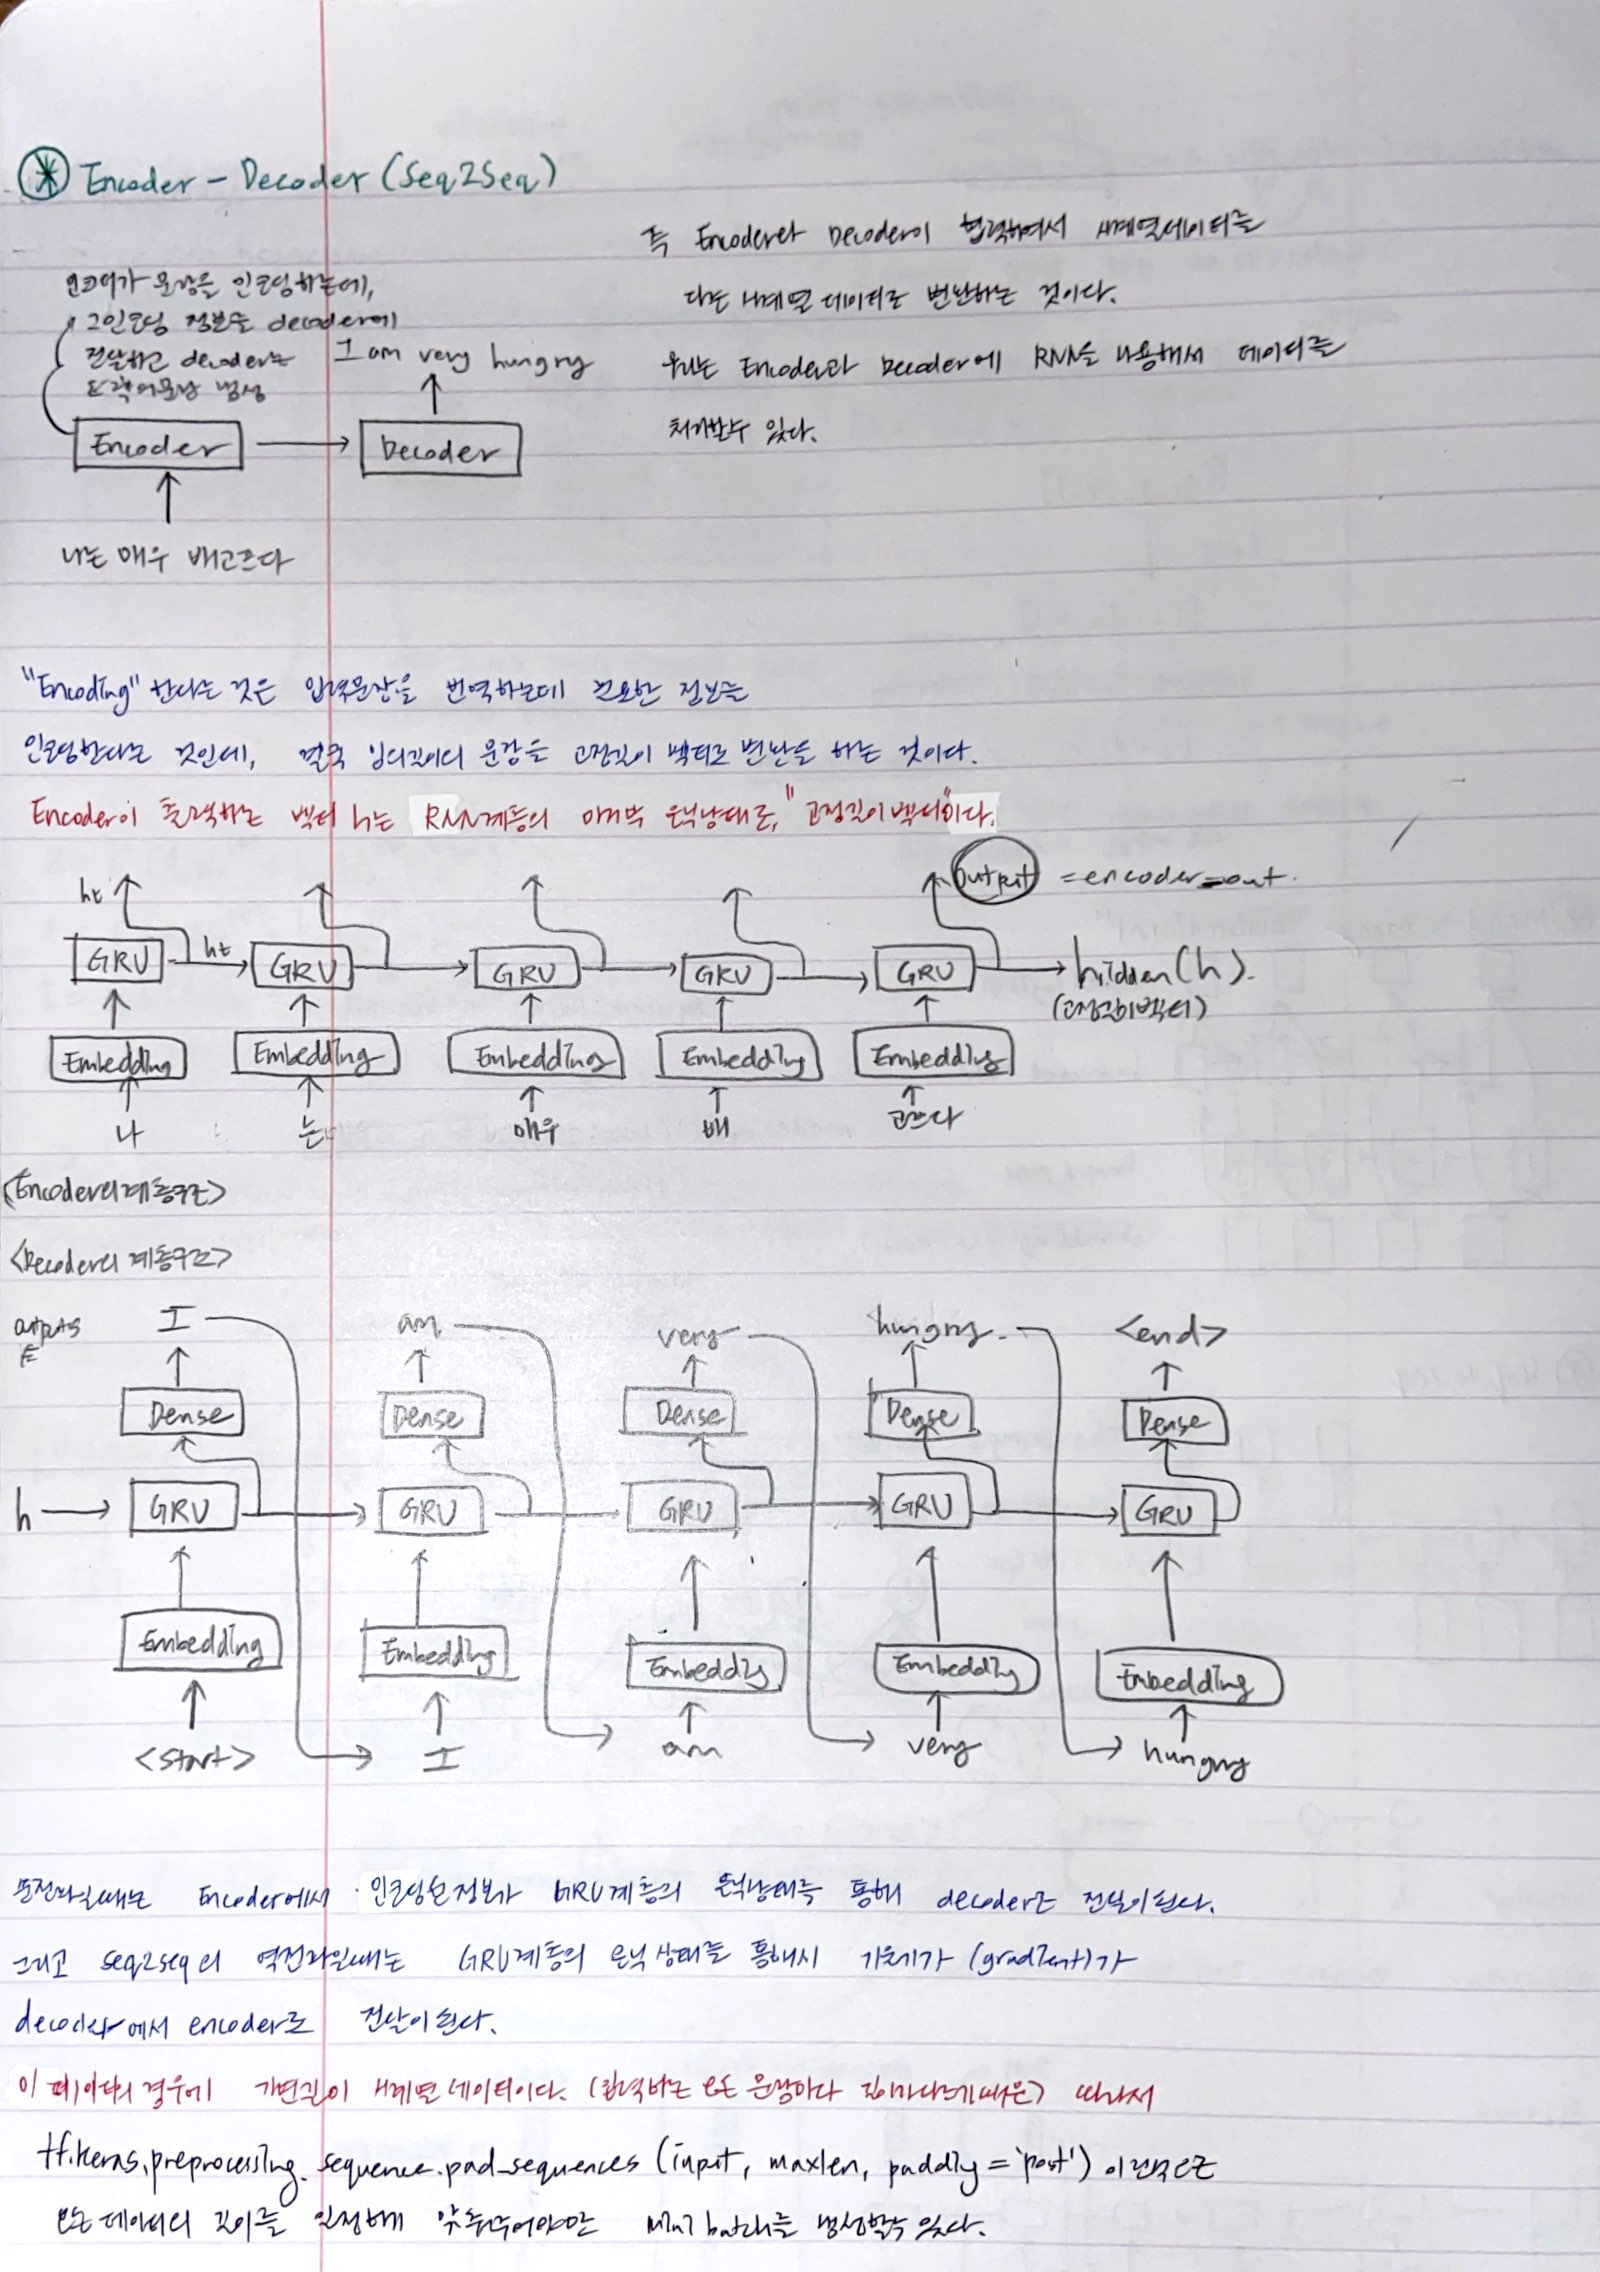

In [240]:
#Dataset 준비
sources = [['I','feel', 'hungry'],
             ['tensorflow', 'is', 'very', 'difficult'],
             ['tensorflow', 'is', 'a', 'framework', 'for', 'deep','learning'],
             ['tensorflow', 'is', 'very', 'fast', 'changing']]
targets = [['나는', '배가', '고프다'],
          ['텐서플로는','매우','어렵다'],
          ['텐서플로는', '딥러닝을','위한','프레임워크이다'],
          ['텐서플로는', '매우','빠르게','변화한다']]

In [241]:
s_vocab = ['<pad>'] + list(sorted(set(sum(sources, []))))
source2_idx = {source : idx for idx, source in enumerate(s_vocab)}
idx2_source = {idx : source for idx, source in enumerate(s_vocab)}

t_vocab = ['<pad>', '<start>', '<end>'] + list(sorted(set(sum(targets, []))))
target2_idx = {target : idx for idx, target in enumerate(t_vocab)}
idx2_target = {idx:target for idx, target in enumerate(t_vocab)}

In [294]:
target2_idx

{'<pad>': 0,
 '<start>': 1,
 '<end>': 2,
 '고프다': 3,
 '나는': 4,
 '딥러닝을': 5,
 '매우': 6,
 '배가': 7,
 '변화한다': 8,
 '빠르게': 9,
 '어렵다': 10,
 '위한': 11,
 '텐서플로는': 12,
 '프레임워크이다': 13}

In [242]:
len(source2_idx), len(target2_idx)

(15, 14)

In [243]:
def preprocess(sequences,max_len, dic,mode = 'source'):
    if mode == 'source':
        s_input = list(map(lambda sentence: [dic.get(word) for word in sentence], sequences))
        s_len = list(map(lambda x:len(x), s_input))
        s_input = pad_sequences(sequences = s_input, maxlen = max_len, padding = 'post', truncating = 'post')
        return s_len, s_input
    elif mode == 'target':
        t_input = list(map(lambda sentence : ['<start>'] + sentence + ['<end>'], sequences))
        t_input = list(map(lambda sentence : [dic.get(word) for word in sentence], t_input))
        t_len = list(map(lambda x: len(x), t_input))
        t_input = pad_sequences(sequences = t_input, maxlen = max_len, padding = 'post', truncating = 'post')
        
        t_output = list(map(lambda sentence : sentence + ['<end>'], sequences))
        t_output = list(map(lambda sentence : [dic.get(word) for word in sentence], t_output))
        t_output = pad_sequences(sequences = t_output, maxlen = max_len, padding = 'post', truncating = 'post')
        
        return t_len, t_input, t_output
        

In [244]:
s_max_len = 10
s_len, s_input = preprocess(sources, s_max_len, source2_idx, mode = 'source')

t_max_len = 12
t_len, t_input, t_output = preprocess(targets, t_max_len, target2_idx, mode = 'target')

In [245]:
s_input, t_input, t_output

(array([[ 1,  7, 10,  0,  0,  0,  0,  0,  0,  0],
        [13, 11, 14,  5,  0,  0,  0,  0,  0,  0],
        [13, 11,  2,  9,  8,  4, 12,  0,  0,  0],
        [13, 11, 14,  6,  3,  0,  0,  0,  0,  0]]),
 array([[ 1,  4,  7,  3,  2,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 12,  6, 10,  2,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 12,  5, 11, 13,  2,  0,  0,  0,  0,  0,  0],
        [ 1, 12,  6,  9,  8,  2,  0,  0,  0,  0,  0,  0]]),
 array([[ 4,  7,  3,  2,  0,  0,  0,  0,  0,  0,  0,  0],
        [12,  6, 10,  2,  0,  0,  0,  0,  0,  0,  0,  0],
        [12,  5, 11, 13,  2,  0,  0,  0,  0,  0,  0,  0],
        [12,  6,  9,  8,  2,  0,  0,  0,  0,  0,  0,  0]]))

In [246]:
data = tf.data.Dataset.from_tensor_slices((s_len, s_input, t_len, t_input, t_output)).shuffle(100).batch(4)

In [247]:
data

<BatchDataset shapes: ((None,), (None, 10), (None,), (None, 12), (None, 12)), types: (tf.int32, tf.int32, tf.int32, tf.int32, tf.int32)>

In [248]:
BUFFER_SIZE = 100
BATCH_SIZE = 4
n_batch = BUFFER_SIZE/BATCH_SIZE

In [249]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.units = enc_units
        self.gru = tf.keras.layers.GRU(self.units, return_sequences = True, return_state = True,
                                      recurrent_activation = 'sigmoid', recurrent_initializer = 'glorot_uniform')
        
    def call(self,x,hidden):
        #먼저 인코더는 embedding layer을 거쳐서
        x = self.embedding(x)
        #GRU, 즉 RNN층에 입력이 되는데, 아래의 코드에서 의미하는 hidden은 은닉층, 즉 GRU layer에서 나오는 것을 의미한다.
        #다만 첫번째 GRU는 입력값이 없으므로 임의로 initialize_hidden_state를 만들어서 dummy입력값을 입력한다.
        inputs, state = self.gru(x, initial_state = hidden)
        return inputs, state
    
    #처음에 GRU Layer에 입력되기 위해서 생성되는 dummy 입력 값이다.
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.units))

In [250]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences = True, return_state = True,
                                      recurrent_activation = 'sigmoid', recurrent_initializer = 'glorot_uniform')
        self.last = tf.keras.layers.Dense(vocab_size)
    
    def call(self,x, hidden, enc_output):
        x = self.embedding(x)
        #LSTM, GRU layer는 각각 3개(hidden2 + output1), 2개(hidden1 + output1)의 출력값을 내보낸다.
        outputs, states = self.gru(x, initial_state = hidden)
        outputs = tf.reshape(outputs, (-1, outputs.shape[2]))
        #dense layer을 통해서 나오는 결과값이 다음 layer의 input 값으로 들어가게 되고
        #GRU를 통해서 나오는 hidden값은 다음 GRU로 저절로 들어가게 된다.
        return self.last(outputs), states
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.dec_units))
        
        

In [251]:
#확실히 unit의 개수를 늘려야 학습의 정확도가 높아지는 것 같다.
encoder = Encoder(len(s_vocab), s_max_len, enc_units = 40, batch_size = BATCH_SIZE)
decoder = Decoder(len(t_vocab), t_max_len, dec_units = 40,batch_size = BATCH_SIZE)

In [252]:
def loss_function(real, pred):
    mask = 1-np.equal(real, 0)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = real, logits = pred) * mask
    return tf.reduce_mean(loss)

optimizer = tf.keras.optimizers.Adam()

In [254]:
epochs = 100
batch_size = 4

for t in range(epochs):
    total_loss = 0
    hidden = encoder.initialize_hidden_state()
    for i, (s_len, s_input, t_len, t_input, t_output) in enumerate(data):
        loss = 0
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(s_input, hidden)
            dec_hidden = enc_hidden
            dec_input = tf.expand_dims([target2_idx['<start>']] * batch_size, 1)
            for j in range(1, t_input.shape[1]):
                prediction, dec_hidden = decoder(dec_input, dec_hidden, enc_output)
                loss += loss_function(t_input[:,j], prediction)
                #잘못된 예측을 반복하면 학습이 느려지고 불안정해 질 수 있다.
                #따라서 teacher forcing method라는 것을 이용하게 된다.
                #이는 계속해서 올바른 정답을 입력값에 넣는 것을 의미한다.
                dec_input = tf.expand_dims(t_input[:,j], 1)
            batch_loss = (loss / int(t_input.shape[1]))
            total_loss += batch_loss
            variables = encoder.variables + decoder.variables
            gradient = tape.gradient(total_loss, variables)
            optimizer.apply_gradients(zip(gradient, variables))
    
    if t % 10 == 0:
        print('Epochs : {} Loss : {:.4f} Batch Loss : {:.4f}'.format(t+1, total_loss/n_batch, batch_loss))

Epochs : 1 Loss : 0.0153 Batch Loss : 0.3815
Epochs : 11 Loss : 0.0138 Batch Loss : 0.3459
Epochs : 21 Loss : 0.0123 Batch Loss : 0.3083
Epochs : 31 Loss : 0.0109 Batch Loss : 0.2719
Epochs : 41 Loss : 0.0094 Batch Loss : 0.2361
Epochs : 51 Loss : 0.0081 Batch Loss : 0.2027
Epochs : 61 Loss : 0.0069 Batch Loss : 0.1734
Epochs : 71 Loss : 0.0060 Batch Loss : 0.1491
Epochs : 81 Loss : 0.0052 Batch Loss : 0.1302
Epochs : 91 Loss : 0.0046 Batch Loss : 0.1161


In [278]:
def prediction(sentence, encoder, deocoder, source2_idx, target2_idx, max_source_len, max_target_len):
    inputs = [source2_idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen = max_source_len, padding = 'post') 
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, 40))]#40은 unit의 개수
    enc_output, enc_hidden = encoder(inputs, hidden)
    
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target2_idx['<start>']], 0)
    
    for i in range(max_target_len):
        prediction, dec_hidden = decoder(dec_input, dec_hidden, enc_output)
        predicted_idx = tf.argmax(prediction[0]).numpy()
        
        result += idx2_target[predicted_idx] + ' '
        
        dec_input = tf.expand_dims([predicted_idx],0)
        if idx2_target.get(predicted_idx) == '<end>':
            return result, sentence
    

In [279]:
sentence = 'tensorflow is very fast learning'
result, sentence = prediction(sentence, encoder, decoder, source2_idx, target2_idx, s_max_len, t_max_len)

In [280]:
result, sentence

('텐서플로는 매우 빠르게 변화한다 <end> ', 'tensorflow is very fast learning')

### 7. Sequence-to-Sequence with Attention
- 기존의 encoder-decoder과 사실상 동일하다.
- 그러나 차이점이라고 한다면 우리가 문맥상의 중요한 데이터를 추출해 내는 것과 같은 능력을 'attention'기능을 추가함으로서 도입하는 것이다.
- 그래서 각각의 unit마다 가중치를 부여하는 방법으로 진행을 한다.
    - encoder의 경우에는 동일하게 하지만
    - decoder의 경우에는 가중치를 추가해서 학습을 시켜야 한다. 
    
 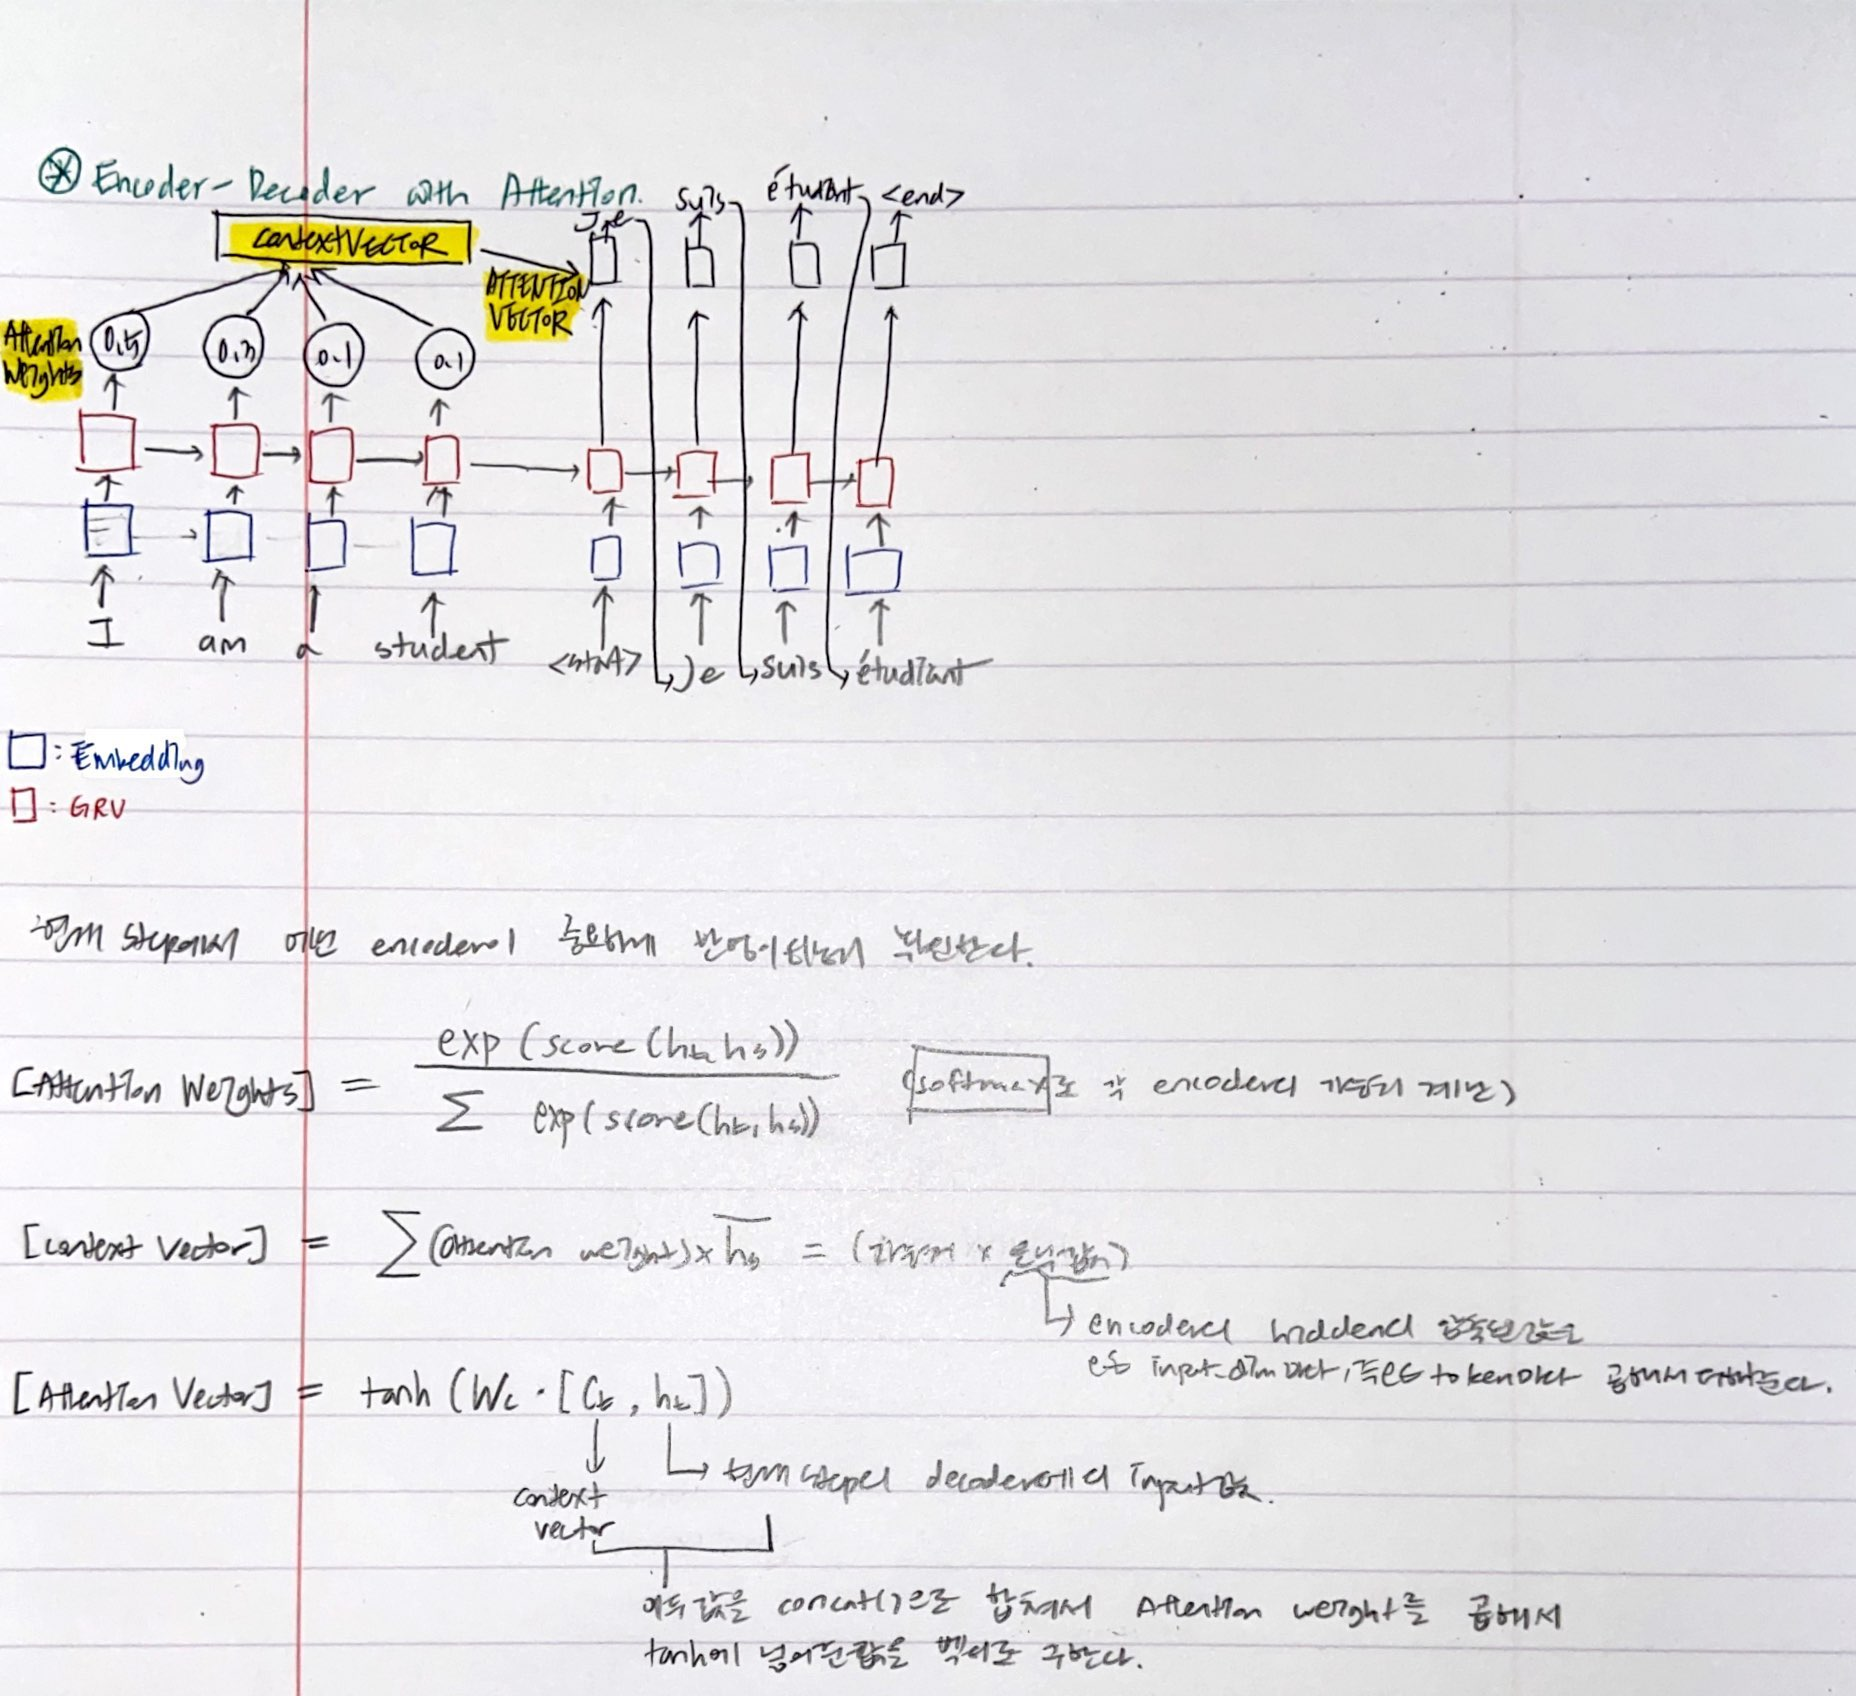   

In [303]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.units = enc_units
        self.gru = tf.keras.layers.GRU(self.units, return_sequences = True, return_state = True,
                                      recurrent_activation = 'sigmoid', recurrent_initializer = 'glorot_uniform')
        
    def call(self,x,hidden):
        #먼저 인코더는 embedding layer을 거쳐서
        x = self.embedding(x)
        #GRU, 즉 RNN층에 입력이 되는데, 아래의 코드에서 의미하는 hidden은 은닉층, 즉 GRU layer에서 나오는 것을 의미한다.
        #다만 첫번째 GRU는 입력값이 없으므로 임의로 initialize_hidden_state를 만들어서 dummy입력값을 입력한다.
        inputs, state = self.gru(x, initial_state = hidden)
        return inputs, state
    
    #처음에 GRU Layer에 입력되기 위해서 생성되는 dummy 입력 값이다.
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.units))

In [304]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.units = dec_units
        self.gru = tf.keras.layers.GRU(self.units, return_sequences = True, return_state = True,
                                      recurrent_activation = 'sigmoid', recurrent_initializer = 'glorot_uniform')
        self.last = tf.keras.layers.Dense(units = vocab_size)
        
        self.w1 = tf.keras.layers.Dense(units = self.units)
        self.w2 = tf.keras.layers.Dense(units = self.units)
        self.v = tf.keras.layers.Dense(1)
    
    def call(self, x, hidden, enc_output):
        #attention_weight를 구해주어야 하기 때문에 encoder에서 받은 hidden layer의 마지막 차원을 확장시킨다.
        #enc_output shape = (batch_size, max_length, hidden_size)
        #hidden shape = (batch_size, hidden_size)
        spread_time_hidden = tf.expand_dims(hidden, axis = 1)
        #spread_time_hidden shape = (batch_size, 1, hidden_size)
        
        #encoding layer으로부터 출력된 은닉층의 값과 출력층의 데이터를 이용해서 softmax를 이용한 가중치 계산을 위해 score을 구해준다.
        score = self.v(tf.nn.tanh(self.w1(enc_output) + self.w2(spread_time_hidden)))
        #score shape = (batch_size, max_length, 1)
        #max_length는 우리가 가중치를 곱해주어야 하는 모든 출력값의 길이이다.(각각에 곱해 주어야 함)
        #따라서 axis를 shape에서 max_length의 위치인 1로 설정해 준 것이다.
        attention_weights = tf.nn.softmax(score, axis = 1)
        
        #attention_weights shape = (batch_size, max_length, 1)
        context_vector = attention_weights * spread_time_hidden
        context_vector = tf.reduce_sum(context_vector,axis = 1)
        
        x = self.embedding(x)
        #x shape = (batch_size, 1, embedding_dim)
        #context_vector을 max_length만큼 되도록 axis = 1을 기준으로 차원을 늘려주고 hidden_size를 기준으로 concat을 해서 합한다.
        x = tf.concat([tf.expand_dims(context_vector, axis = 1), x], axis = -1)
        #concated x shape = (batch_size, 1, embedding_dim + hidden_size)
        
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        #output shape = (batch_size, hidden_size)
        x = self.last(output)
        
        return x, state, attention_weights
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.units))

In [309]:
units = 40
embedding_dim = 32
encoder = Encoder(len(source2_idx), embedding_dim, units, BATCH_SIZE)
decoder =  Decoder(len(target2_idx), embedding_dim, units, BATCH_SIZE)

In [310]:
tf.expand_dims(t_input[:,1], 1)

<tf.Tensor: shape=(4, 1), dtype=int32, numpy=
array([[ 4],
       [12],
       [12],
       [12]])>

In [315]:
epochs = 200
for epoch in range(epochs):
    total_loss = 0
    for i, (s_len, s_input, t_len, t_input, t_output) in enumerate(data):
        loss = 0
        with tf.GradientTape() as tape:
            hidden = encoder.initialize_hidden_state()
            enc_output, enc_hidden = encoder(s_input, hidden)
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([target2_idx['<start>']] * BATCH_SIZE, axis = 1)
            for j in range(1, t_input.shape[1]):
                prediction, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_output)
                loss += loss_function(t_input[:, j], prediction)
                #다음의 decoder의 입력값으로 이전 단계의 정답 값이 제공이 된다.
                #따라서 이를 입력해 주기 위해서 차원을 맞추어 주어야 한다.
                dec_input = tf.expand_dims(t_input[:, j], axis = 1)
            
            loss /= int(t_input.shape[1])
            total_loss += loss
            variables = encoder.variables + decoder.variables
            gradient = tape.gradient(loss, variables)
            optimizer.apply_gradients(zip(gradient, variables))
    
    if epoch % 20 == 0:
        print('Epoch : {} Loss : {:.4f} Batch Loss : {:.4f}'.format(epoch+1, total_loss/n_batch, loss)) 
        

Epoch : 1 Loss : 0.0396 Batch Loss : 0.9896
Epoch : 21 Loss : 0.0267 Batch Loss : 0.6669
Epoch : 41 Loss : 0.0133 Batch Loss : 0.3325
Epoch : 61 Loss : 0.0076 Batch Loss : 0.1892
Epoch : 81 Loss : 0.0055 Batch Loss : 0.1375
Epoch : 101 Loss : 0.0050 Batch Loss : 0.1250
Epoch : 121 Loss : 0.0047 Batch Loss : 0.1185
Epoch : 141 Loss : 0.0039 Batch Loss : 0.0983
Epoch : 161 Loss : 0.0032 Batch Loss : 0.0793
Epoch : 181 Loss : 0.0030 Batch Loss : 0.0746


**확실히 Attention값을 추가해 주었더니 성능이 많이 올라갔음을 알 수 있다**

- 이렇게 train 함수까지 직접 구현하고 특히나 마지막에 encoder-decoder class와 내부에서 어떻게 가중치를 부여하고 학습을 위해 다음 차원으로 넣는지 구현해 보니 **차원 맞추기의 중요성**에 대해 깨닫게 되었다.
- 항상 직접 함수를 구현할 때 뿐 아니라 언제나 모델링을 할 때에 차원을 신경 써야 할 것 같다.